#### Objective : Univariate Time Series Modelling using DARTS for model training and weight & Biases for model logging to beat the becnhmark model already provided

#### Created By : Ashwini Kumar

#### Start Date : 16th March 2022

#### Steps Involved :

    1. Read the data from the csv file and split into train and validation splits 
    
    2. Try NBeats Model over all the Timeseries and log results
    


In [1]:
# Import the required packages 
from darts import TimeSeries
import pandas as pd
import tqdm as notebook_tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import NBEATSModel

In [2]:
# Function to read the csv file from given location & parse datetime properly

def load_dataframe(filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

# Call the function to read the data properly

df = load_dataframe("_Final_master_df_2022_2017_v9_with_Bolzano.csv")
df.head(5)

,Date,RequestedQTY,GoodsIssuedQTY,InvoicedQTY,PDO number,req_Illy,req_Teddy,req_Thun,req_other,inv_Illy,...,BOL_B2B AA Thun,BOL_B2B P&P Thun,BOL_B2B Sorter Thun,BOL_B2B Sorter SM Thun,BOL_B2B Sorter BVB Thun,BOL_B2B Sorter riassortimenti WHS,BOL_B2C Thun,BOL_B2C Sorter Thun,BOL_B2C P2L Thun,BOL_Inbound Thun
0,2016-12-26,1616.0,1613.0,1613.0,135,635.0,0.0,981.0,0.0,635.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,227928.0,217034.0,216049.0,12075,12851.0,0.0,215041.0,36.0,11866.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-09,176524.0,167839.0,166669.0,10663,14442.0,0.0,162078.0,4.0,13272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-16,289548.0,280089.0,279048.0,12330,14555.0,0.0,274961.0,32.0,13514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-23,248337.0,234044.0,232787.0,15942,15244.0,0.0,233063.0,30.0,13987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns


Index(['Date', 'RequestedQTY', 'GoodsIssuedQTY', 'InvoicedQTY', 'PDO number',
       'req_Illy', 'req_Teddy', 'req_Thun', 'req_other', 'inv_Illy',
       'inv_Teddy', 'inv_Thun', 'inv_other', 'req_ThunB2B', 'req_ThunB2C',
       'req_ThunB2B_AA', 'req_ThunB2B_PP', 'req_ThunB2B_Sorter',
       'req_ThunB2B_Sort_BVB', 'req_ThunB2B_Sort_SM',
       'req_ThunB2B_SortSM_10more_no', 'req_ThunB2B_SortSM_10more_yes',
       'Thun_PDOs', 'req_BowlPros', 'inv_BowlPros', 'AVGperPDO_Thun_ReqQ',
       'AVGperPDO_Thun_SKU', 'AVGperPDOThunB2B_ReqQ', 'AVGperPDOThunB2B_InvQ',
       'AVGperPDOThunB2B_SKU', 'AVGperPDOThunB2B_PDOs',
       'AVGperPDOThunB2C_ReqQ', 'AVGperPDOThunB2C_InvQ',
       'AVGperPDOThunB2C_SKU', 'AVGperPDOThunB2C_PDOs',
       'AVGperPDOThunB2Bsort_ReqQ', 'AVGperPDOThunB2Bsort_InvQ',
       'AVGperPDOThunB2Bsort_SKU', 'ThunB2Bsort_PDOs',
       'AVGperPDOThunB2Bpp_ReqQ', 'AVGperPDOThunB2Bpp_InvQ',
       'AVGperPDOThunB2Bpp_SKU', 'ThunB2Bpp_PDOs', 'AVGperPDOThunB2Baa_ReqQ',
     

In [4]:
# Function create the Time Series from Dataframe using a function

def df_to_timeseries(df,time_column, timeseries):
    series = TimeSeries.from_dataframe(df, time_column,timeseries)
    return (series)

In [5]:

from darts.metrics import mae
def eval_error(actual_values,pred_values):
    return mae(actual_values,pred_values)

In [6]:
## Lets try a basic NBeats Model and see how it performs

In [7]:
def model_pipeline(train_data, val_data, benchmark_data,timeseries_input):

    model = NBEATSModel(input_chunk_length=32, output_chunk_length=8, n_epochs = 100, random_state = 0)
    # fitting the model
    model = model.fit(train_data, verbose = False)
    
    pred_series = model.historical_forecasts(
    timeseries_input,
    start=pd.Timestamp("2020-12-07"),
    forecast_horizon=4,
    stride=8,
    retrain=False,
    verbose=False,
     )

    import matplotlib.pyplot as plt
    plt.figure()
    plt.rcParams["figure.figsize"] = (20,8)
    timeseries_input.plot()
    pred_series.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
    benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
    plt.legend()
    print ("Our Model Backtest Error")
    print (eval_error(val_data,pred_series))
    print ("Our Model Actual Error")
    print (eval_error(val_data,model.predict(n = 58, series = train_data)))
    print (" Benchmark Error")
    print (eval_error(val_data,benchmark_data))
    
#     import matplotlib.pyplot as plt

#     plt.rcParams["figure.figsize"] = (20,8)
#     timeseries_input.plot()
    model.predict(n = 58, series = train_data).plot(label='predict', low_quantile=0.05, high_quantile=0.95)
#     benchmark_data.plot(label='benchmark', low_quantile=0.05, high_quantile=0.95)
    plt.legend()
    plt.show()

In [8]:
def call_timeseries(train_column,benchmark_column):
    timeseries_input = df_to_timeseries(df,"Date",train_column)

    benchmark_input = df_to_timeseries(df,"Date",benchmark_column)
    # Set aside the data since 2021 
    train_data, val_data = timeseries_input.split_before(pd.Timestamp('2021-01-04'))

    train_benchmark_ignore, benchmark_data = benchmark_input.split_before(pd.Timestamp('2021-01-04'))
    
    return train_data,val_data,benchmark_data,timeseries_input

[2022-03-23 01:37:29,994] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-23 01:37:29,994] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.


Running for  req_ThunB2B_AA


[2022-03-23 01:37:30,239] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:37:30,239] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:37:30,239] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-23 01:37:30,239] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in 

Our Model Backtest Error
13350.028331198157
Our Model Actual Error
18482.31216859081
 Benchmark Error
23509.689655172413


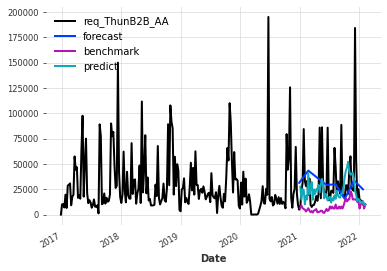

[2022-03-23 01:43:00,956] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-23 01:43:00,956] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.


Running for  req_ThunB2B_PP


[2022-03-23 01:43:01,173] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:43:01,173] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:43:01,177] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-23 01:43:01,177] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in 

Our Model Backtest Error
9080.810564880418
Our Model Actual Error
11798.48465258888
 Benchmark Error
11758.01724137931


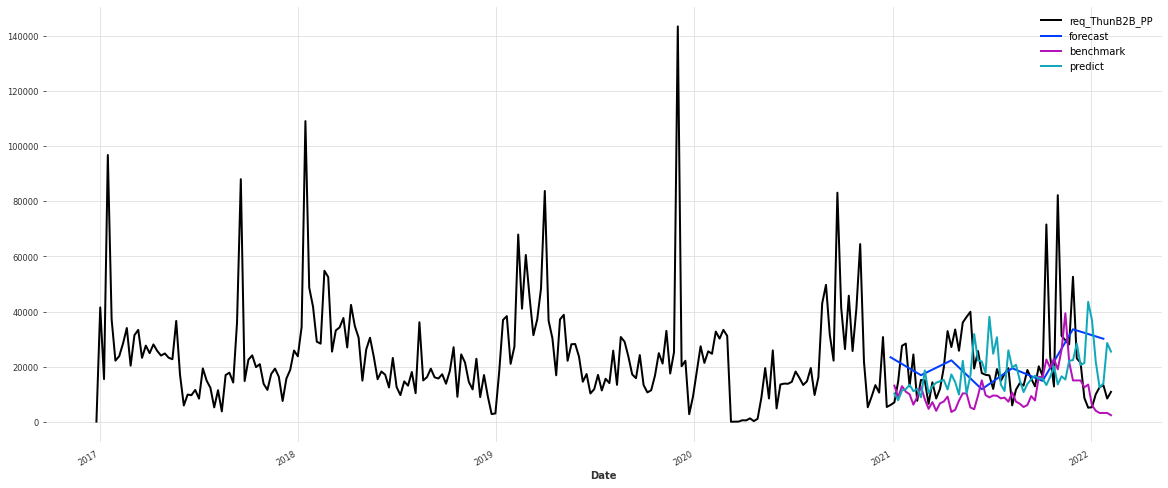

[2022-03-23 01:48:20,208] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-23 01:48:20,208] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.


Running for  req_ThunB2B_Sorter


[2022-03-23 01:48:20,437] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:48:20,437] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:48:20,439] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-23 01:48:20,439] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in 

Our Model Backtest Error
55184.90420575692
Our Model Actual Error
54528.53930749579
 Benchmark Error
33980.206896551725


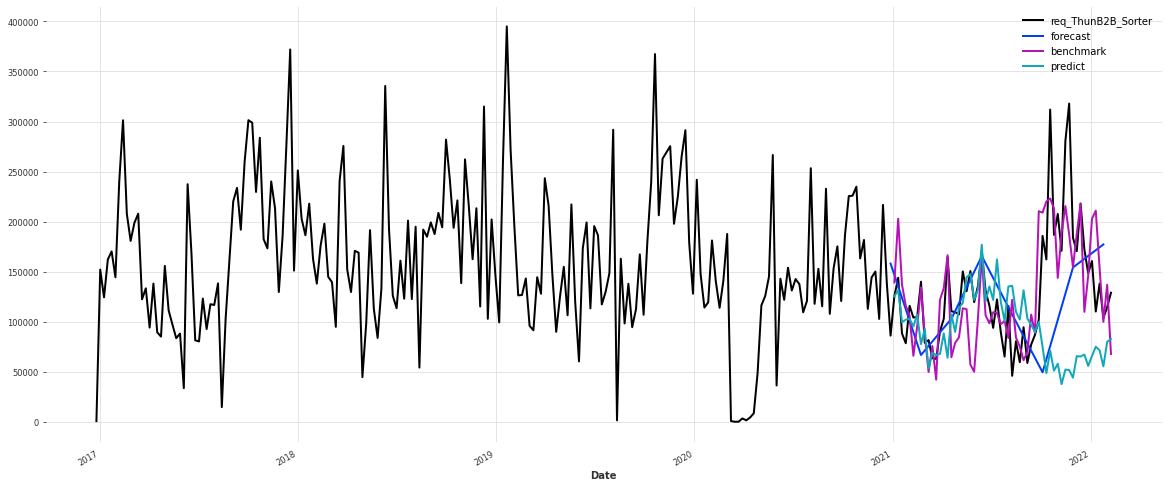

[2022-03-23 01:59:05,096] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.
[2022-03-23 01:59:05,096] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 171 samples.


Running for  req_ThunB2C


[2022-03-23 01:59:05,771] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:59:05,771] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-23 01:59:05,778] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-23 01:59:05,778] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in 

Our Model Backtest Error
10517.88556219661
Our Model Actual Error
23682.072492176296
 Benchmark Error
4774.6551724137935


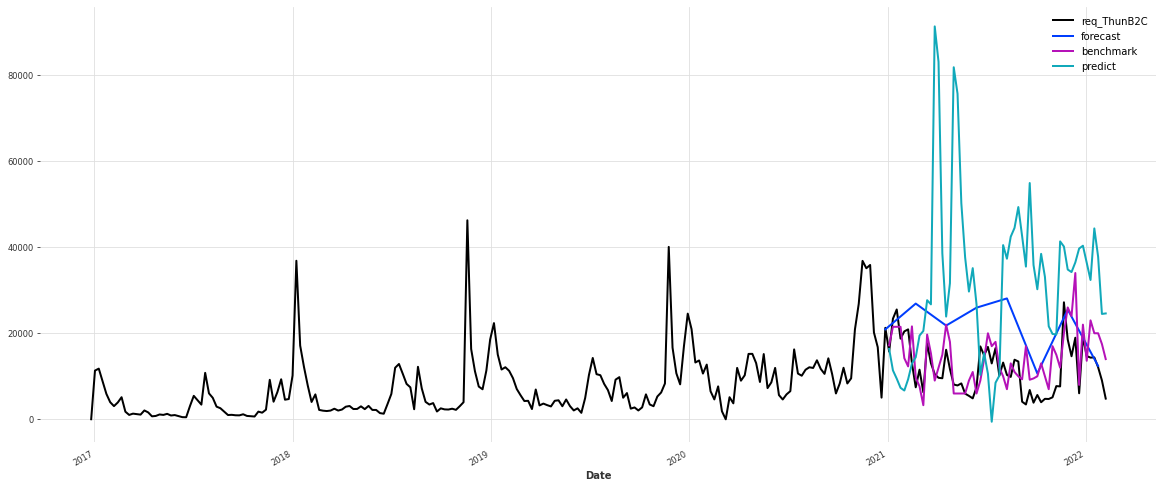

In [9]:
train_series = ["req_ThunB2B_AA", "req_ThunB2B_PP", "req_ThunB2B_Sorter", "req_ThunB2C"]
benchmark_series = ["BOL_B2B AA Thun", "BOL_B2B P&P Thun", "BOL_B2B Sorter Thun", "BOL_B2C Thun"]

for i in range(len(train_series)):
    
    print ("Running for " , train_series[i])
    train_data,val_data,benchmark_data,timeseries_input = call_timeseries(train_series[i],benchmark_series[i])
    model_pipeline(train_data,val_data,benchmark_data,timeseries_input)
    